In [206]:
%matplotlib inline
import pandas as pd
import numpy as np
X = pd.read_csv("data/dataMungingSave.csv", index_col=0)
X.head()

,COUNTRY,YEAR,NY.GDP.MKTP.CD_0,NY.GDP.PCAP.CD_0,AG.PRD.CREL.MT_0,AG.YLD.CREL.KG_0,AG.PRD.CROP.XD_0,AG.PRD.FOOD.XD_0,AG.LND.CREL.HA_0,AG.PRD.LVSK.XD_0,...,SP.DYN.TFRT.IN_4,TX.VAL.MRCH.CD.WT_4,TX.VAL.MRCH.WL.CD_4,TX.VAL.MRCH.RS.ZS_4,TX.VAL.MRCH.HI.ZS_4,TM.VAL.MRCH.CD.WT_4,TM.VAL.MRCH.WL.CD_4,TM.VAL.MRCH.RS.ZS_4,TM.VAL.MRCH.HI.ZS_4,TG.VAL.TOTL.GD.ZS_4
0,AFG,1971,1.673333e+09,161.384702,3826000.0,1224.516,83.05,70.20,3124500.0,60.38,...,7.450,100000000.0,99900000.0,47.314314,42.712713,141000000.0,145386000.0,32.425405,57.253106,13.161423
1,AFG,1977,1.733333e+09,144.173944,4270000.0,1279.592,91.25,73.56,3337000.0,58.45,...,7.449,306000000.0,313137000.0,45.115397,35.590492,328000000.0,458652000.0,45.553055,45.343964,21.467268
2,AFG,1978,2.155555e+09,175.027098,4351000.0,1301.915,94.92,76.02,3342000.0,61.00,...,7.449,321000000.0,269156000.0,43.718141,27.069432,395000000.0,450516000.0,53.467801,34.542835,21.696969
3,AFG,1979,2.366667e+09,188.085136,4481000.0,1316.392,97.68,78.24,3404000.0,63.38,...,7.449,474000000.0,435015000.0,60.016551,18.152248,425000000.0,551216000.0,68.909647,24.561515,24.310830
4,AFG,1980,2.555556e+09,199.164809,4624000.0,1362.404,102.93,83.72,3394000.0,69.07,...,7.449,670000000.0,670474000.0,64.592065,19.471896,841000000.0,494754000.0,60.669343,32.162044,41.491344


In [209]:
predictionFeature = 'SP.ADO.TFRT'
columns=['CountryCode', 'IndicatorCode', 'Year', 'Value']
data = pd.read_csv("data/indicators.csv", usecols=(columns))
pData = data[data.IndicatorCode == predictionFeature]
yearsForward = 5

# TODO optimize later
futureValues = [pData[(pData.CountryCode == row[0]) & (pData.Year == int(row[1]) + yearsForward)].Value.values for row in X.values]
currentValues = [pData[(pData.CountryCode == row[0]) & (pData.Year == int(row[1]))].Value.values for row in X.values]
rowsWithPredictions = [(len(futureValues[i]) == 1 & len(currentValues[i]) == 1) for i in range(len(futureValues))]
values = [[futureValues[i][0] - currentValues[i][0], futureValues[i][0], currentValues[i][0]] for i in range(len(futureValues)) if (len(futureValues[i]) == 1 & len(currentValues[i]) == 1)]
X = X[rowsWithPredictions]
y = pd.DataFrame(values, columns=['Change', 'FutureValue', 'CurrentValue'])
print (len(X))
print (len(y))
y.head()

5147
5147


,Change,FutureValue,CurrentValue
0,3.5760,148.8970,145.3210
1,5.4360,155.2270,149.7910
2,5.4976,156.3758,150.8782
3,5.5592,157.5246,151.9654
4,5.6208,158.6734,153.0526


In [217]:
from sklearn.cross_validation import train_test_split
X_data = X.drop(['COUNTRY', 'YEAR'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y.Change, test_size=0.2, random_state=0)

In [218]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [240]:
import seaborn as sb
import matplotlib.pyplot as plt
def getGraphData(clf, country, displayRelativeValues):
    indices = (X.COUNTRY == country)
    realValues = y[indices].values
    plotData = X[indices]
    
    dataPoints = []
    plotDataValues = plotData.drop(['COUNTRY', 'YEAR'], axis=1).values
    plotDataScaledValues = scaler.transform(plotDataValues)
    predictions = clf.predict(plotDataScaledValues)
    for i in range(len(plotData.YEAR)):
        relativePortion = 0 if displayRelativeValues else realValues[i][2] 
        dataPoints.append([country + "_PREDICTED", plotData.YEAR.values[i] + yearsForward, predictions[i] + relativePortion, True])
        dataPoints.append([country + "_REAL", plotData.YEAR.values[i] + yearsForward, realValues[i][0] + relativePortion, False])
    return len(plotData.YEAR), dataPoints

In [241]:
def testClfWithCountries(clf, countries, displayRelativeValues):
    countryGraphData = []
    for country in countries:
        numYears, dataPoints = getGraphData(clf, country, displayRelativeValues)
        countryGraphData.append(dataPoints)
    
    countryGraphDataFlattened = [item for sublist in countryGraphData for item in sublist]
    
    graphData = pd.DataFrame(countryGraphDataFlattened, columns=['COUNTRY', 'YEAR', 'VALUE', 'IS_PREDICTED'])
    
    numYears = len(countries)
    
    linestyles = ["--", "-"]*numYears
    markers= ["x", "o"]*numYears
    palette = np.repeat(sb.color_palette("Set1", n_colors=numYears, desat=.5), 2, axis=0)

    fig, (ax) = plt.subplots(1,1, figsize=(20,7))
    graph = sb.pointplot(x='YEAR', y='VALUE', hue='COUNTRY', linestyles=linestyles, markers=markers, palette=palette, data=graphData, ax=ax)

In [242]:
import random
def testClf(clf, numCountries=5, displayRelativeValues=False):
    countries = ['AFG', 'ALB', 'DZA', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS', 'AUT',
           'AZE', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BOL', 'BIH',
           'BRA', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN',
           'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'CRI', 'CIV',
           'HRV', 'CUB', 'CYP', 'CZE', 'ZAR', 'DNK', 'DOM', 'EAP', 'ECU',
           'EGY', 'SLV', 'EST', 'ETH', 'ECA', 'FJI', 'FIN', 'FRA', 'GAB',
           'GEO', 'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY',
           'HTI', 'HIC', 'HND', 'HUN', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
           'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KOR', 'KWT',
           'KGZ', 'LAO', 'LAC', 'LVA', 'LBN', 'LBR', 'LBY', 'LTU', 'LMY',
           'LMC', 'LUX', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT',
           'MRT', 'MUS', 'MEX', 'MNA', 'MIC', 'MDA', 'MNG', 'MAR', 'MOZ',
           'NPL', 'NLD', 'NZL', 'NIC', 'NER', 'NGA', 'NOR', 'OMN', 'PAK',
           'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'POL', 'PRT', 'QAT', 'ROM',
           'RUS', 'RWA', 'STP', 'SAU', 'SEN', 'SLE', 'SVK', 'SVN', 'SLB',
           'ZAF', 'SAS', 'ESP', 'LKA', 'VCT', 'SSA', 'SDN', 'SUR', 'SWE',
           'CHE', 'SYR', 'TJK', 'TZA', 'THA', 'BHS', 'GMB', 'TGO', 'TTO',
           'TUN', 'TUR', 'TKM', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMC',
           'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'WLD', 'YEM', 'ZMB', 'ZWE']
    #random.shuffle(countries)
    testClfWithCountries(clf, countries[0:numCountries], displayRelativeValues)

In [238]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)
#cv_scores = cross_val_score(clf, X_test, test, cv=4)
#cv_scores
clf.score(X_test, y_test)

0.64533962964997438

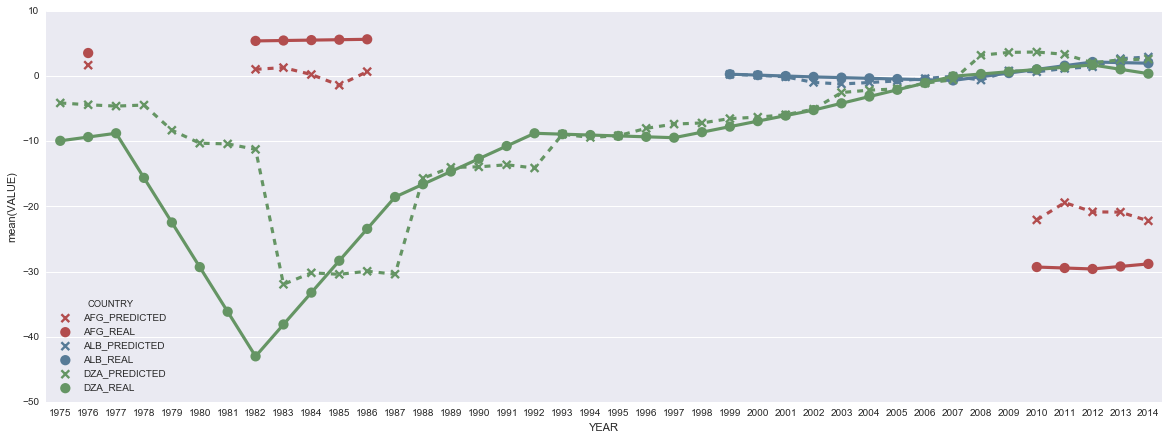

In [244]:
testClf(clf, 3, True)

In [229]:
from sklearn.svm import SVR
clf = SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.41330523879655923

In [56]:
#from sklearn.grid_search import GridSearchCV
#param_grid = [
#    {'C': [10], 'kernel': ['linear']},
#    {'C': [10], 'gamma': [0.03], 'kernel': ['rbf']},
#]
#clf = GridSearchCV(SVR(), param_grid, cv=4)
#clf = clf.fit(X_train, train)
#clf = clf.best_estimator_
#clf.score(X_test, test)

In [248]:
import lasagne
import theano
import theano.tensor as T

In [249]:
X_train.shape

(4117, 315)

In [250]:
y_train.shape

(4117,)

In [258]:
input_var = T.tensor4('X')
target_var = T.ivector('y')

In [259]:
from lasagne.nonlinearities import leaky_rectify, softmax
network = lasagne.layers.InputLayer((None, 3, 32, 32), input_var)
network = lasagne.layers.Conv2DLayer(network, 64, (3, 3),
                                     nonlinearity=leaky_rectify)
network = lasagne.layers.Conv2DLayer(network, 32, (3, 3),
                                     nonlinearity=leaky_rectify)
network = lasagne.layers.Pool2DLayer(network, (3, 3), stride=2, mode='max')
network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
                                    128, nonlinearity=leaky_rectify,
                                    W=lasagne.init.Orthogonal())
network = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, 0.5),
                                    10, nonlinearity=softmax)

In [260]:
# create loss function
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
        network, lasagne.regularization.l2)

In [261]:
# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01,
                                            momentum=0.9)


In [262]:
train_fn = theano.function([input_var, target_var], loss, updates=updates)


In [267]:
for epoch in range(100):
    loss = 0
    for i in range(len(y_train)):
        loss += train_fn(X_train[i], y_train[i])
    print("Epoch %d: Loss %g" % (epoch + 1, loss / len(y_train)))

TypeError: ('Bad input argument to theano function with name "<ipython-input-262-a9a5249efc94>:1"  at index 0(0-based)', 'Wrong number of dimensions: expected 4, got 1 with shape (315,).')

In [295]:
from keras.models import Sequential
from keras.layers import Dense, Activation
def baseline_model():
    model = Sequential()
    model.add(Dense(35, input_dim=315, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [296]:
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)